# Earthquake Visualization

At first, we have to import datasets to Dataframe.

In [1]:
import numpy as np
import pandas as pd
import glob

# for multiple files
PATH = './All/*.csv'
data = pd.concat(map(pd.read_csv, glob.glob(PATH)))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93203 entries, 0 to 1044
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         93203 non-null  object
 1   Time         93203 non-null  object
 2   震央地名         93203 non-null  object
 3   Lat          93203 non-null  object
 4   Long         93203 non-null  object
 5   Depth        93203 non-null  int64 
 6   M            93203 non-null  object
 7   最大震度         93203 non-null  object
 8   Source.Name  89371 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.1+ MB
None


For analyzation, we use only date, time, position, depth and magnitude.

In [2]:
data = data[['Date', 'Time', 'Lat', 'Long', 'Depth', 'M']]
data = data.replace(to_replace="不明",value="NaN")
data['M'] = data['M'].astype(np.float32)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 0 to 1044
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    85334 non-null  object 
 1   Time    85334 non-null  object 
 2   Lat     85334 non-null  object 
 3   Long    85334 non-null  object 
 4   Depth   85334 non-null  int64  
 5   M       85334 non-null  float32
dtypes: float32(1), int64(1), object(4)
memory usage: 4.2+ MB


As you can see, latitude and longitude of the positions are not in decimal. For analyzation, we have to convert from dms to decimal.

In [3]:
import re
def dms2dd(s):
    degrees, minutes, direction = re.split('[°\']+', s)
    dd = float(degrees) + float(minutes)/60
    return dd

Apply dms2dd function to the dataframe

In [4]:
data['Lat'] = data['Lat'].apply(dms2dd)
data['Long'] = data['Long'].apply(dms2dd)

In some places, the data is incorrect or unusable, so we have to remove all of these. After removing, we have to check the amount of data for analyzation. After conversion, we have to cast the data to be float.

In [5]:
import numpy as np
data = data.astype({'Lat': np.float64, 'Long': np.float64, 'M': np.float64, 'Depth': np.float64})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 0 to 1044
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    85334 non-null  object 
 1   Time    85334 non-null  object 
 2   Lat     85334 non-null  float64
 3   Long    85334 non-null  float64
 4   Depth   85334 non-null  float64
 5   M       85334 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.6+ MB


# Convert 'Date' and 'Time' to Timestamp

At first, we have to use array to store the Timestamp after convert from 'Date' and 'Time'.

In [6]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # if the date and time cannot be converted
        timestamp.append('ValueError')

Insert Timestamp to dataframe

In [7]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

As you can see above, the data in dataframe is not in order by time, so we have to reorder it. We also have to remove the Timestamp Error

In [8]:
data = data[data.Timestamp != 'ValueError']
data.sort_values(by='Timestamp', inplace=True)
data.head()

,Date,Time,Lat,Long,Depth,M,Timestamp
680,1/1/1985,0:58:14,36.103333,141.156667,38.0,3.9,473356694.0
679,1/1/1985,13:19:52,35.825000,137.565000,11.0,3.9,473401192.0
678,1/1/1985,19:41:54,42.181667,142.558333,29.0,3.2,473424114.0
677,1/2/1985,3:31:04,37.018333,141.791667,46.0,4.6,473452264.0
676,1/3/1985,3:54:45,43.361667,145.801667,48.0,3.1,473540085.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 680 to 1537
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       85334 non-null  object 
 1   Time       85334 non-null  object 
 2   Lat        85334 non-null  float64
 3   Long       85334 non-null  float64
 4   Depth      85334 non-null  float64
 5   M          85334 non-null  float64
 6   Timestamp  85334 non-null  float64
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


# Visualization

To understand the position of earthquake, we should plot the position of the earthquake and see what happended.

/Users/phongwitsrikokcharoen/miniconda3/envs/earthquake/lib/python3.10/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/phongwitsrikokcharoen/miniconda3/envs/earthquake/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


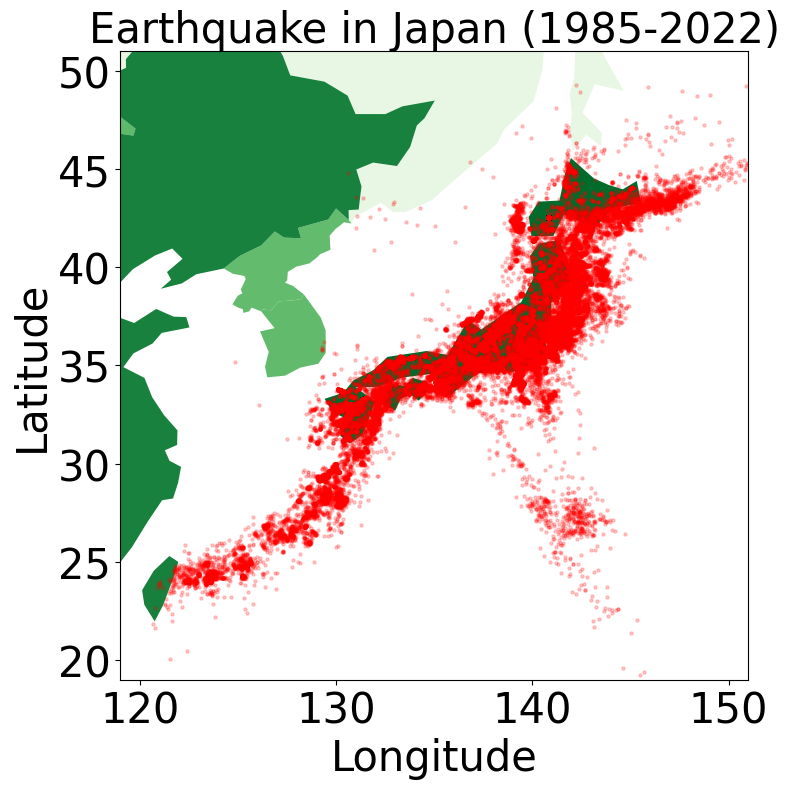

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
# load geopandas mapdata
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# initialize
world = world.to_crs({'init': 'epsg:4326'}) # World Geodetic System 1984 (gps)
# Visualize
limx = [119, 151]
limy = [19, 51]
fig, ax = plt.subplots(figsize=(14,8))
plt.rcParams["figure.autolayout"] = True
ax.set_title("Earthquake in Japan (1985-2022)", fontsize=30)
ax.set_xlim(limx)
ax.set_ylim(limy)
ax = world.plot(ax=ax, alpha=1.0, cmap='Greens')

# quake plots
plt.scatter(data.Long, data.Lat, s=5, alpha = 0.2, color="red")
plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
plt.tick_params(labelsize=30)
plt.savefig("earthquake.svg", format="svg")
plt.show()

We can separate the earthquake's occurence annualy to observe the number of earthquake each years.

In [11]:
import seaborn

data['date'] = data['Date'].apply(lambda x: pd.to_datetime(x))
data['year'] = data['date'].apply(lambda x: str(x).split('-')[0])

/Users/phongwitsrikokcharoen/miniconda3/envs/earthquake/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


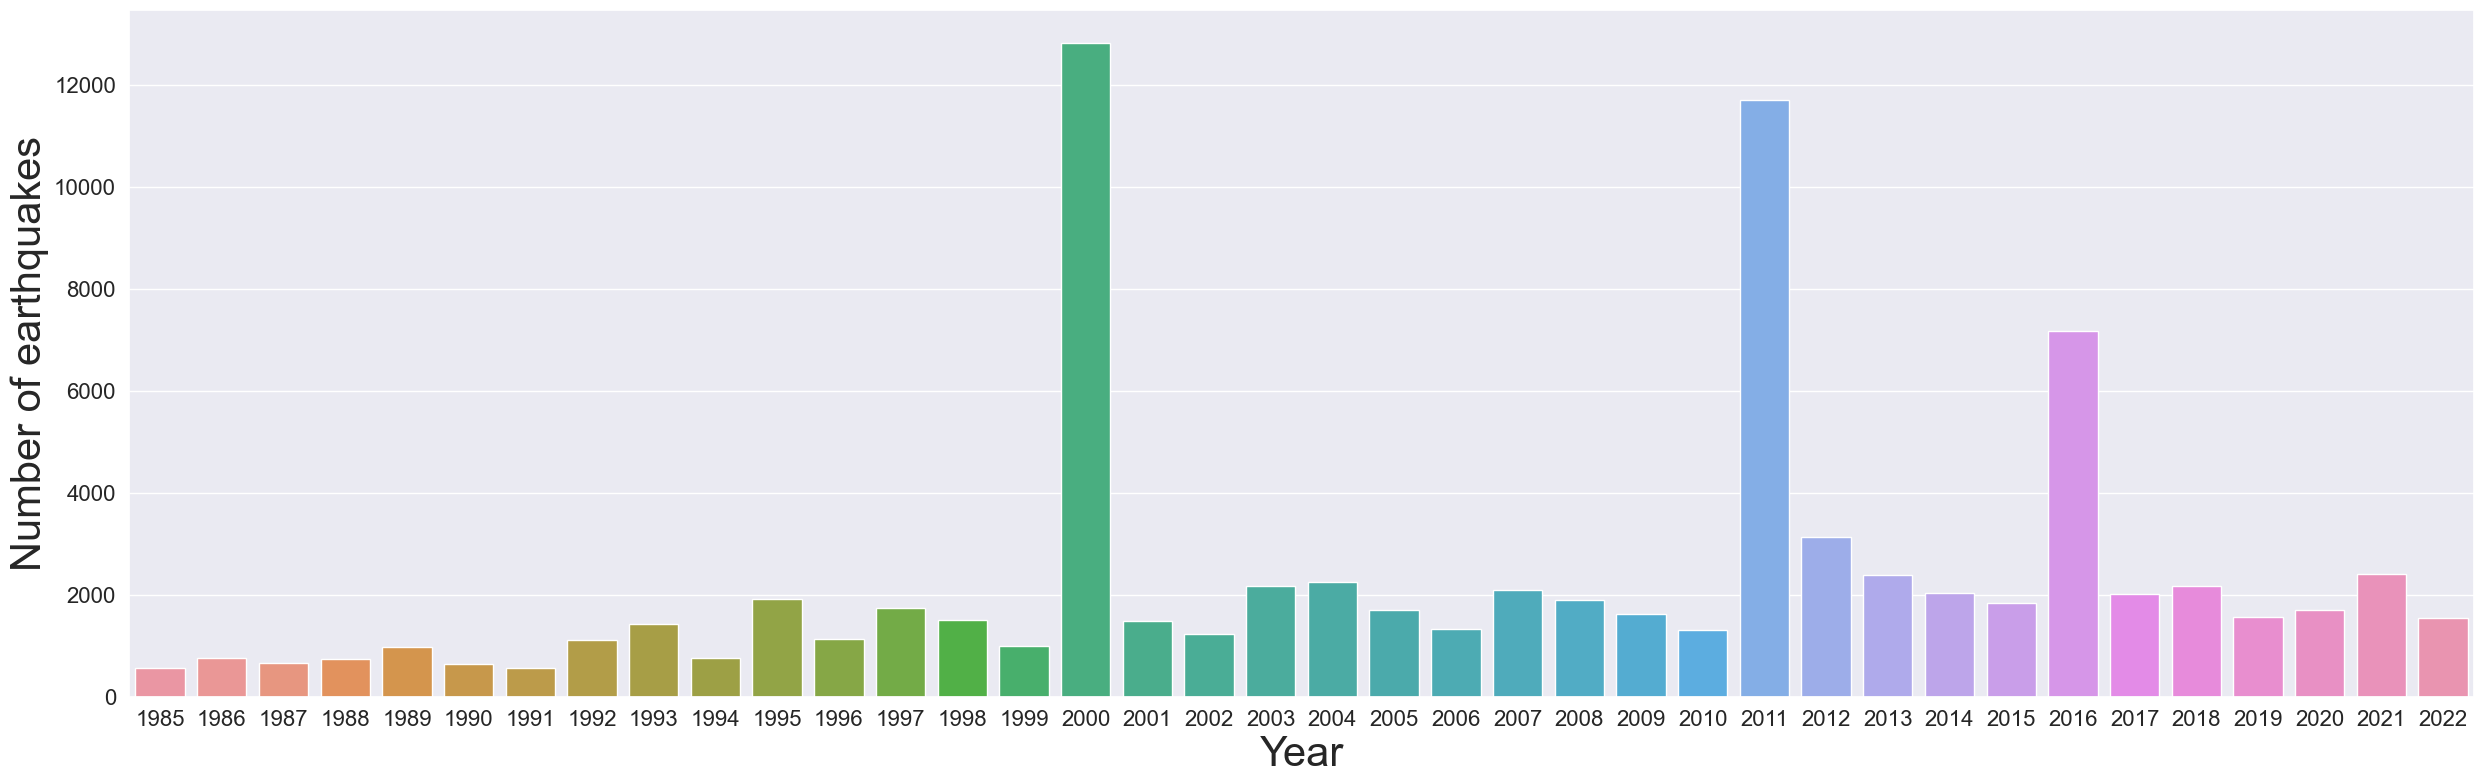

In [12]:
plt.figure(figsize=(25, 8))
seaborn.set(font_scale=1.0)
seaborn.countplot(x="year", data=data)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Number of earthquakes', fontsize=30)
plt.tick_params(labelsize=16)
plt.savefig('year.svg')
plt.show()

## Magnitude Size and Number of Occurences

We can also check the relationship between magnitude size and number of occurences.

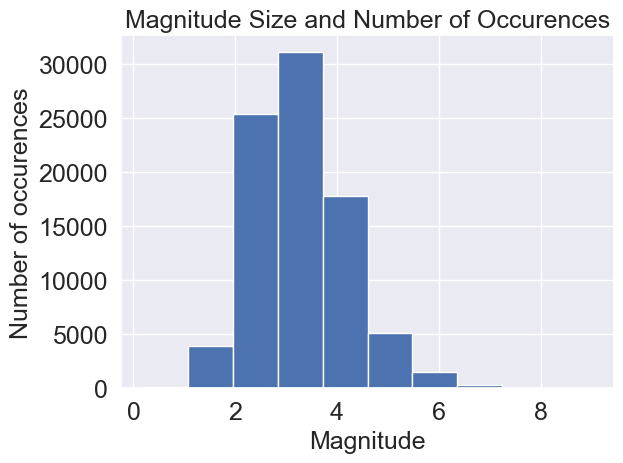

In [13]:
plt.hist(data['M'])
plt.xlabel('Magnitude', fontsize=18)
plt.ylabel('Number of occurences', fontsize=18)
plt.tick_params(labelsize=18)
plt.title('Magnitude Size and Number of Occurences', fontweight=20, fontsize=18)
plt.savefig('num.svg')
plt.show()

We can also see the relationship between Magnitude and Depth of the earthquake.

In [14]:
data.head()

,Date,Time,Lat,Long,Depth,M,Timestamp,date,year
680,1/1/1985,0:58:14,36.103333,141.156667,38.0,3.9,473356694.0,1985-01-01,1985
679,1/1/1985,13:19:52,35.825000,137.565000,11.0,3.9,473401192.0,1985-01-01,1985
678,1/1/1985,19:41:54,42.181667,142.558333,29.0,3.2,473424114.0,1985-01-01,1985
677,1/2/1985,3:31:04,37.018333,141.791667,46.0,4.6,473452264.0,1985-01-02,1985
676,1/3/1985,3:54:45,43.361667,145.801667,48.0,3.1,473540085.0,1985-01-03,1985


# Gutenberg-Richter Law Analysis
Reference : https://en.wikipedia.org/wiki/Gutenberg–Richter_law

In [15]:
counts = data['M'].apply(np.floor)
counts = counts.value_counts()
counts = counts.apply(np.log10)
counts = counts.drop([0.0, 1.0, 2.0])
counts = np.array(counts)
print(counts)

[4.51952611 4.16313155 3.55291145 2.82542612 1.8920946  0.69897
 0.30103   ]


/Users/phongwitsrikokcharoen/miniconda3/envs/earthquake/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


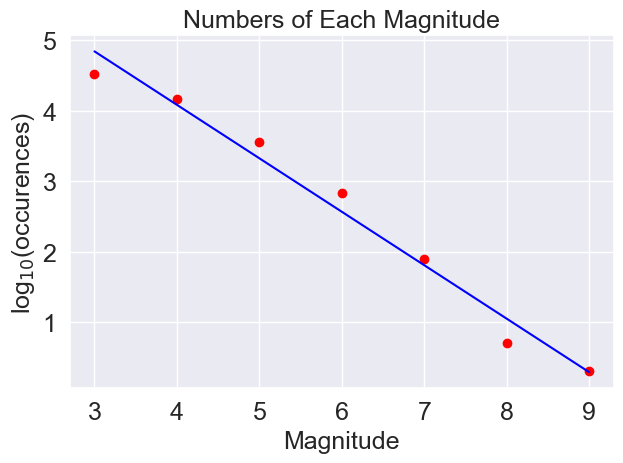

In [16]:
from sklearn.linear_model import LinearRegression

X = np.array([3, 4, 5, 6, 7, 8, 9])
X = X.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X, counts)
coef, intercept = reg.coef_, reg.intercept_

plt.scatter(X, counts, color = 'red')
plt.plot(X, reg.predict(X), color = 'blue')
plt.title('Numbers of Each Magnitude', fontsize=18)
plt.xlabel('Magnitude', fontsize=18)
plt.ylabel('log$_{10}$(occurences)', fontsize=18)
plt.tick_params(labelsize=18)
plt.savefig('num_log.svg')
plt.show()

In [17]:
reg.score(X, counts)

0.9781934655564023

/Users/phongwitsrikokcharoen/miniconda3/envs/earthquake/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


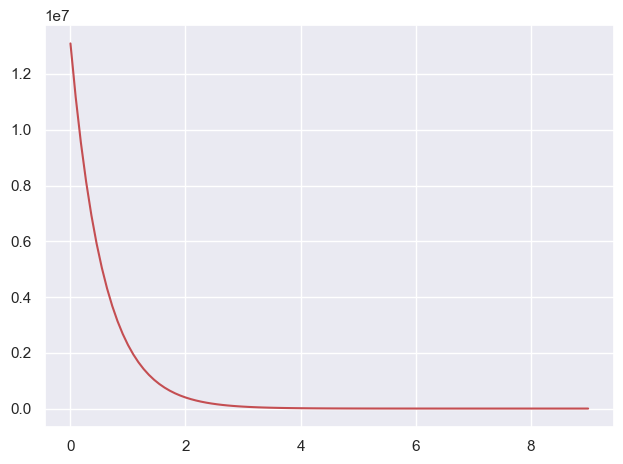

In [18]:
x = np.linspace(0, 9, 100)
y = 10**(-0.758737*x+7.117147)

fig = plt.figure()
plt.plot(x, y, 'r')
plt.show()